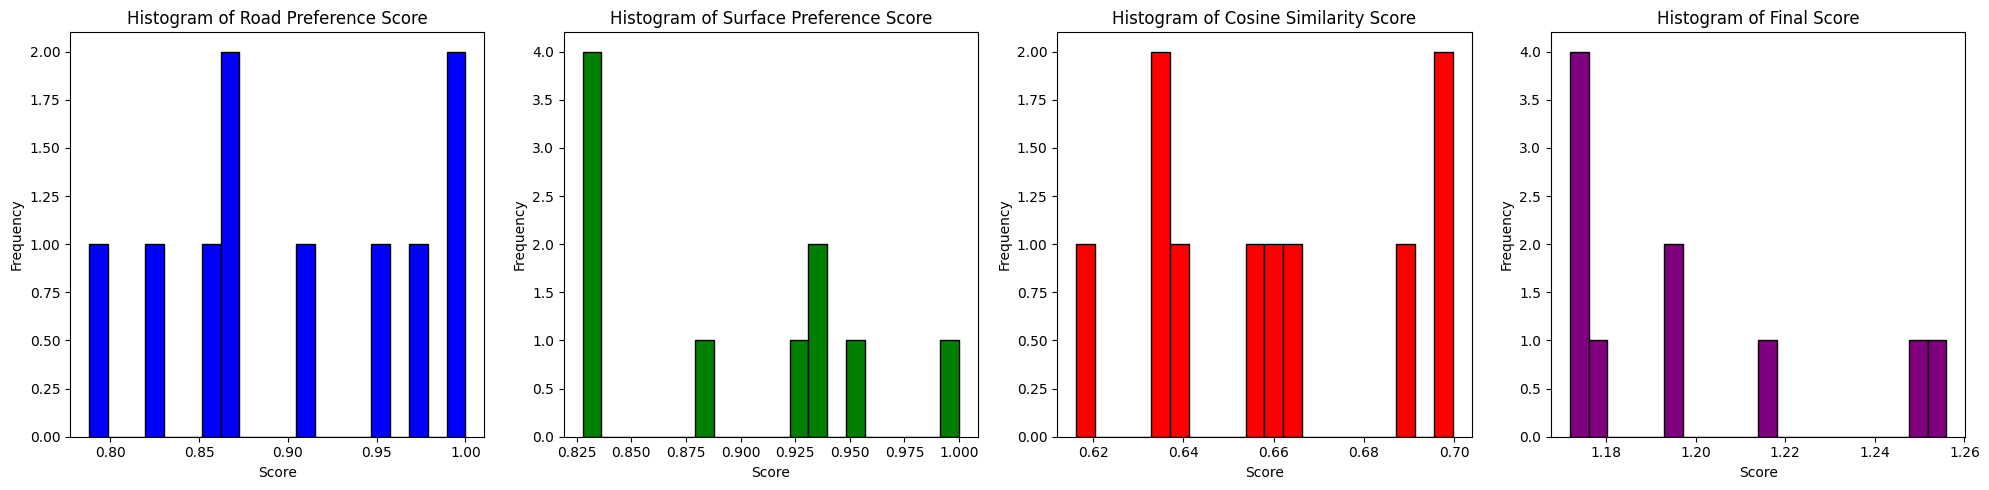

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from geopy.distance import geodesic
import folium
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json('bijgewerkte_gebruikersprofielen_v2.json', lines=True)
routes_df = pd.read_json('combined_lines_volledig.json', lines=True)

# Preprocessing van de routegegevens: bereken gemiddelde waarden
routes_df[['mean_altitude', 'mean_latitude', 'mean_longitude']] = routes_df[['altitude', 'latitude', 'longitude']].applymap(np.mean)

# Bewaar de originele waarden voor visualisatie
original_cols = ['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value', 'altitude_change', 'distance', 'mean_altitude', 'average_condition_value']
user_profiles_df[[f'orig_{col}' for col in original_cols[:4]]] = user_profiles_df[original_cols[:4]]
routes_df[[f'orig_{col}' for col in original_cols[4:]]] = routes_df[original_cols[4:]]

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Schaal features met RobustScaler
robust_scaler = RobustScaler()
features_to_scale = ['average_speeds', 'average_altitude_changes', 'average_distances', 'altitude_change', 'distance', 'mean_altitude']
user_profiles_df[features_to_scale[:3]] = robust_scaler.fit_transform(user_profiles_df[features_to_scale[:3]])
routes_df[features_to_scale[3:]] = robust_scaler.fit_transform(routes_df[features_to_scale[3:]])

# Bereken gewichten voor gebruikerskenmerken
gewichten = user_profiles_df.set_index('userId')[['weight_std_altitude_change', 'weight_std_distance']].to_dict('index')

# Functie om voorkeursscores te berekenen
def calculate_preference_score(user_preferences, route_features):
    total_user_pref = sum(user_preferences.values())
    total_route_feat = sum(route_features.values())
    if total_user_pref == 0: total_user_pref = 1
    if total_route_feat == 0: total_route_feat = 1
    score = 0
    for feature_type in user_preferences.keys():
        user_freq = user_preferences.get(feature_type, 0) / total_user_pref
        route_freq = route_features.get(feature_type, 0) / total_route_feat
        score += min(user_freq, route_freq)
    return score * 100

# Functie om cosine similarity te berekenen
def calculate_cosine_similarity(user_values, route_values):
    return cosine_similarity([user_values], [route_values])[0][0]

def visualize_routes_on_map(user_id, user_profiles_df, recommended_routes):
    # Vind de locatie van de gebruiker en zijn/haar voorkeuren
    user_data = user_profiles_df[user_profiles_df['userId'] == user_id].iloc[0]
    user_location = (user_data['most_common_lat'], user_data['most_common_lon'])

    # Maak een Folium-kaart met de locatie van de gebruiker als middelpunt
    map_obj = folium.Map(location=user_location, zoom_start=12)

    # Voeg een marker toe voor de locatie van de gebruiker
    folium.Marker(
        location=user_location,
        popup=f'Gebruiker {user_id}<br>Gemiddelde afstand: {user_data["orig_average_distances"]} km',
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(map_obj)

    # Definieer een lijst van kleuren voor de routes
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

    # Voeg de aanbevolen routes toe aan de kaart met verschillende kleuren
    for index, route in recommended_routes.iterrows():
        route_coords = list(zip(route['latitude'], route['longitude']))
        route_color = colors[index % len(colors)]  # Gebruik modulo om door de kleurenlijst te lopen
        folium.PolyLine(
            route_coords,
            color=route_color,
            weight=5,
            opacity=0.7,
            popup=(f"Route ID: {route['id']}<br>"
                   f"Afstand: {route['orig_distance']} km<br>"
                   f"Hoogteverandering: {route['orig_altitude_change']} m<br>"
                   f"Wegen: {', '.join([f'{k}: {v}' for k, v in route['highways'].items()])}<br>"
                   f"Ondergronden: {', '.join([f'{k}: {v}' for k, v in route['surfaces'].items()])}")
        ).add_to(map_obj)

    return map_obj

# Voeg de implementatie van calculate_scores_and_recommend hier toe
def calculate_scores_and_recommend(user_profiles_df, routes_df, user_id, top_n=10):
    user_data = user_profiles_df.loc[user_profiles_df['userId'] == user_id].iloc[0]
    user_weights = gewichten.get(user_id, {'weight_std_altitude_change': 1, 'weight_std_distance': 1})

    routes_df['distance_to_user'] = routes_df.apply(
        lambda row: geodesic(
            (user_data['most_common_lat'], user_data['most_common_lon']),
            (row['mean_latitude'], row['mean_longitude'])
        ).kilometers, axis=1)

    def calculate_route_scores(row):
        user_values = np.array([
            user_data['average_altitude_changes'] * user_weights['weight_std_altitude_change'],
            user_data['average_distances'] * user_weights['weight_std_distance'],
            1  # Voor distance_to_user wordt verondersteld dat deze altijd 1 is
        ])
        route_values = np.array([row['altitude_change'], row['distance'], row['distance_to_user']])
        cosine_sim = calculate_cosine_similarity(user_values, route_values)
        road_pref_score = calculate_preference_score(user_data['voorkeur_wegen'], row['highways'])
        surface_pref_score = calculate_preference_score(user_data['voorkeur_ondergronden'], row['surfaces'])
        return pd.Series([cosine_sim, road_pref_score, surface_pref_score])

    routes_df[['cosine_similarity_score', 'road_preference_score', 'surface_preference_score']] = routes_df.apply(calculate_route_scores, axis=1)
    
    scaler = MinMaxScaler()
    routes_df[['road_preference_score', 'surface_preference_score']] = scaler.fit_transform(
        routes_df[['road_preference_score', 'surface_preference_score']]
    )

    cosine_similarity_weight = 1.0
    road_preference_weight = 0.3
    surface_preference_weight = 0.3

    routes_df['final_score'] = (
        routes_df['cosine_similarity_score'] * cosine_similarity_weight +
        routes_df['road_preference_score'] * road_preference_weight +
        routes_df['surface_preference_score'] * surface_preference_weight
    )

    recommended_routes = routes_df.sort_values(by='final_score', ascending=False).head(top_n)
    return recommended_routes
# Functie om histograms te plotten voor de gegeven features
def plot_histograms_for_scores(routes_df, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    
    # Histogram voor road_preference_score
    plt.subplot(1, 4, 1)  # 1x4 grid, positie 1
    plt.hist(routes_df['road_preference_score'], bins=20, edgecolor='black', color='blue')
    plt.title('Histogram of Road Preference Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Histogram voor surface_preference_score
    plt.subplot(1, 4, 2)  # 1x4 grid, positie 2
    plt.hist(routes_df['surface_preference_score'], bins=20, edgecolor='black', color='green')
    plt.title('Histogram of Surface Preference Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Histogram voor cosine_similarity_score
    plt.subplot(1, 4, 3)  # 1x4 grid, positie 3
    plt.hist(routes_df['cosine_similarity_score'], bins=20, edgecolor='black', color='red')
    plt.title('Histogram of Cosine Similarity Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Histogram voor final_score
    plt.subplot(1, 4, 4)  # 1x4 grid, positie 4
    plt.hist(routes_df['final_score'], bins=20, edgecolor='black', color='purple')
    plt.title('Histogram of Final Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Implementatie van visualize_and_plot
def visualize_and_plot(user_id, user_profiles_df, routes_df):
    recommended_routes = calculate_scores_and_recommend(user_profiles_df, routes_df, user_id)
    map_obj = visualize_routes_on_map(user_id, user_profiles_df, recommended_routes)
    plot_histograms_for_scores(recommended_routes)
    return map_obj

# Test en visualisatie
# sample_user_id = 8974660
sample_user_id = 8899244
# sample_user_id = 5325166
# sample_user_id = 6361870
map_obj = visualize_and_plot(sample_user_id, user_profiles_df, routes_df)
# In een Jupyter-notebook, toon de kaart direct
map_obj


C:\Users\Ruben\AppData\Local\Temp\ipykernel_3252\1806228707.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df[['cosine_similarity_score', 'road_preference_score', 'surface_preference_score']] = routes_df.apply(calculate_route_scores, axis=1)
C:\Users\Ruben\AppData\Local\Temp\ipykernel_3252\1806228707.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_df[['cosine_similarity_score', 'road_preference_score', 'surface_preference_score']] = routes_df.apply(calculate_route_scores, axis=1)


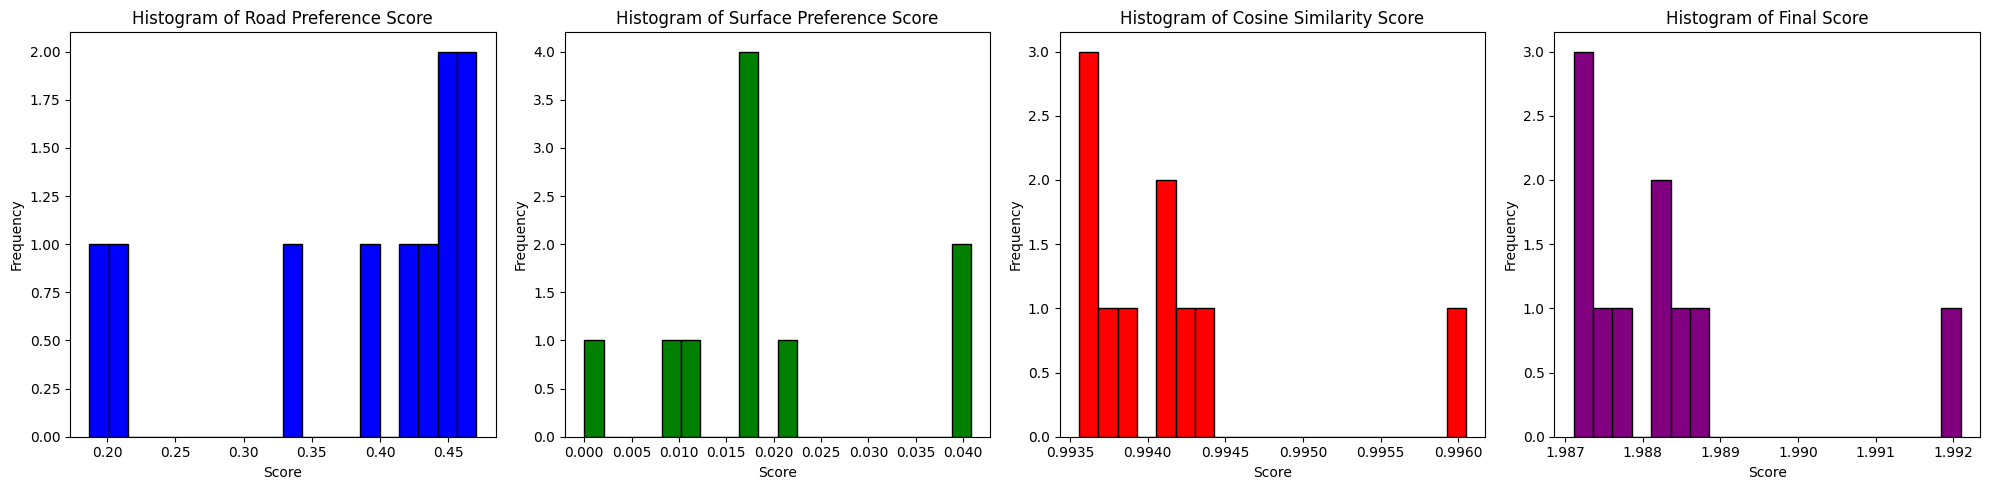

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from geopy.distance import geodesic
import folium
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Laad de gebruikersprofielen en routes
user_profiles_df = pd.read_json('bijgewerkte_gebruikersprofielen_v2.json', lines=True)
routes_df = pd.read_json('combined_lines_volledig.json', lines=True)

# Preprocessing van de routegegevens: bereken gemiddelde waarden
routes_df[['mean_altitude', 'mean_latitude', 'mean_longitude']] = routes_df[['altitude', 'latitude', 'longitude']].applymap(np.mean)

# Bewaar de originele waarden voor visualisatie
original_cols = ['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value', 'altitude_change', 'distance', 'mean_altitude', 'average_condition_value']
user_profiles_df[[f'orig_{col}' for col in original_cols[:4]]] = user_profiles_df[original_cols[:4]]
routes_df[[f'orig_{col}' for col in original_cols[4:]]] = routes_df[original_cols[4:]]

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Schaal features met RobustScaler
robust_scaler = RobustScaler()
features_to_scale = ['average_speeds', 'average_altitude_changes', 'average_distances', 'altitude_change', 'distance', 'mean_altitude']
user_profiles_df[features_to_scale[:3]] = robust_scaler.fit_transform(user_profiles_df[features_to_scale[:3]])
routes_df[features_to_scale[3:]] = robust_scaler.fit_transform(routes_df[features_to_scale[3:]])

# Bereken gewichten voor gebruikerskenmerken
gewichten = user_profiles_df.set_index('userId')[['weight_std_altitude_change', 'weight_std_distance']].to_dict('index')

# Functie om voorkeursscores te berekenen
def calculate_preference_score(user_preferences, route_features):
    total_user_pref = sum(user_preferences.values())
    total_route_feat = sum(route_features.values())
    if total_user_pref == 0: total_user_pref = 1
    if total_route_feat == 0: total_route_feat = 1
    score = 0
    for feature_type in user_preferences.keys():
        user_freq = user_preferences.get(feature_type, 0) / total_user_pref
        route_freq = route_features.get(feature_type, 0) / total_route_feat
        score += min(user_freq, route_freq)
    return score * 100

# Functie om cosine similarity te berekenen
def calculate_cosine_similarity(user_values, route_values):
    return cosine_similarity([user_values], [route_values])[0][0]

def visualize_routes_on_map(user_id, user_profiles_df, recommended_routes):
    # Vind de locatie van de gebruiker en zijn/haar voorkeuren
    user_data = user_profiles_df[user_profiles_df['userId'] == user_id].iloc[0]
    user_location = (user_data['most_common_lat'], user_data['most_common_lon'])

    # Maak een Folium-kaart met de locatie van de gebruiker als middelpunt
    map_obj = folium.Map(location=user_location, zoom_start=12)

    # Voeg een marker toe voor de locatie van de gebruiker
    folium.Marker(
        location=user_location,
        popup = f'Gebruiker {user_id}<br>Gemiddelde afstand: {user_data["orig_average_distances"]} km <br> Hoogteverandering: {user_data["orig_average_altitude_changes"]} m <br> Voorkeur wegen: {", ".join([f"{k}: {v}" for k, v in user_data["voorkeur_wegen"].items()])} <br> Voorkeur ondergronden: {", ".join([f"{k}: {v}" for k, v in user_data["voorkeur_ondergronden"].items()])} <br> Voorkeur snelheid: {user_data["orig_average_speeds"]} km/u <br> Voorkeur ondergronden: {", ".join([f"{k}: {v}" for k, v in user_data["voorkeur_ondergronden"].items()])}',
        icon=folium.Icon(color='green', icon='info-sign')
    ).add_to(map_obj)

    # Definieer een lijst van kleuren voor de routes
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

    # Voeg de aanbevolen routes toe aan de kaart met verschillende kleuren
    for index, route in recommended_routes.iterrows():
        route_coords = list(zip(route['latitude'], route['longitude']))
        route_color = colors[index % len(colors)]  # Gebruik modulo om door de kleurenlijst te lopen
        folium.PolyLine(
            route_coords,
            color=route_color,
            weight=5,
            opacity=0.7,
            popup=(f"Route ID: {route['id']}<br>"
                   f"userId: {route['userId']}<br>"
                   f"Afstand: {route['orig_distance']} km<br>"
                   f"Hoogteverandering: {route['orig_altitude_change']} m<br>"
                   f"Wegen: {', '.join([f'{k}: {v}' for k, v in route['highways'].items()])}<br>"
                   f"Ondergronden: {', '.join([f'{k}: {v}' for k, v in route['surfaces'].items()])}")
        ).add_to(map_obj)

    return map_obj

# Voeg de implementatie van calculate_scores_and_recommend hier toe
def calculate_scores_and_recommend(user_profiles_df, routes_df, user_id, top_n=10):
    user_data = user_profiles_df.loc[user_profiles_df['userId'] == user_id].iloc[0]
    user_weights = gewichten.get(user_id, {'weight_std_altitude_change': 1, 'weight_std_distance': 1})

    routes_df['distance_to_user'] = routes_df.apply(
        lambda row: geodesic(
            (user_data['most_common_lat'], user_data['most_common_lon']),
            (row['mean_latitude'], row['mean_longitude'])
        ).kilometers, axis=1)

    # Filter routes die door de gebruiker zelf geregistreerd zijn
    routes_df = routes_df[routes_df['userId'] != user_id]

    def calculate_route_scores(row):
        user_values = np.array([
            user_data['average_altitude_changes'] * user_weights['weight_std_altitude_change'],
            user_data['average_distances'] * user_weights['weight_std_distance'],
            1  # Voor distance_to_user wordt verondersteld dat deze altijd 1 is
        ])
        route_values = np.array([row['altitude_change'], row['distance'], row['distance_to_user']])
        cosine_sim = calculate_cosine_similarity(user_values, route_values)
        road_pref_score = calculate_preference_score(user_data['voorkeur_wegen'], row['highways'])
        surface_pref_score = calculate_preference_score(user_data['voorkeur_ondergronden'], row['surfaces'])
        return pd.Series([cosine_sim, road_pref_score, surface_pref_score])

    routes_df[['cosine_similarity_score', 'road_preference_score', 'surface_preference_score']] = routes_df.apply(calculate_route_scores, axis=1)
    
    scaler = MinMaxScaler()
    routes_df[['road_preference_score', 'surface_preference_score']] = scaler.fit_transform(
        routes_df[['road_preference_score', 'surface_preference_score']]
    )

    cosine_similarity_weight = 2.0
    road_preference_weight = 0.0
    surface_preference_weight = 0.0

    routes_df['final_score'] = (
        routes_df['cosine_similarity_score'] * cosine_similarity_weight +
        routes_df['road_preference_score'] * road_preference_weight +
        routes_df['surface_preference_score'] * surface_preference_weight
    )

    recommended_routes = routes_df.sort_values(by='final_score', ascending=False).head(top_n)
    return recommended_routes

# Functie om histograms te plotten voor de gegeven features
def plot_histograms_for_scores(routes_df, figsize=(20, 5)):
    plt.figure(figsize=figsize)
    
    # Histogram voor road_preference_score
    plt.subplot(1, 4, 1)  # 1x4 grid, positie 1
    plt.hist(routes_df['road_preference_score'], bins=20, edgecolor='black', color='blue')
    plt.title('Histogram of Road Preference Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Histogram voor surface_preference_score
    plt.subplot(1, 4, 2)  # 1x4 grid, positie 2
    plt.hist(routes_df['surface_preference_score'], bins=20, edgecolor='black', color='green')
    plt.title('Histogram of Surface Preference Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Histogram voor cosine_similarity_score
    plt.subplot(1, 4, 3)  # 1x4 grid, positie 3
    plt.hist(routes_df['cosine_similarity_score'], bins=20, edgecolor='black', color='red')
    plt.title('Histogram of Cosine Similarity Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # Histogram voor final_score
    plt.subplot(1, 4, 4)  # 1x4 grid, positie 4
    plt.hist(routes_df['final_score'], bins=20, edgecolor='black', color='purple')
    plt.title('Histogram of Final Score')
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Implementatie van visualize_and_plot
def visualize_and_plot(user_id, user_profiles_df, routes_df):
    recommended_routes = calculate_scores_and_recommend(user_profiles_df, routes_df, user_id)
    map_obj = visualize_routes_on_map(user_id, user_profiles_df, recommended_routes)
    plot_histograms_for_scores(recommended_routes)
    return map_obj

# Test en visualisatie
# sample_user_id = 8974660
# sample_user_id = 8899244
# sample_user_id = 5325166
sample_user_id = 6361870
map_obj = visualize_and_plot(sample_user_id, user_profiles_df, routes_df)
# In een Jupyter-notebook, toon de kaart direct
map_obj
